In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics


from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import (
    mean_squared_error, r2_score, accuracy_score, auc, roc_curve, roc_auc_score, confusion_matrix
)
from sklearn.model_selection import (
    train_test_split,    
    StratifiedKFold,
    GridSearchCV, RandomizedSearchCV
)

# Loading Data

In [11]:
# 读取数据
data = pd.read_csv('./data_processed/data_first_record_with_commorbidities.csv', index_col=0)
print(f'INFO: Data shape: {data.shape}')

# 填充缺失值
print(f'INFO: Has Missing Value (before): {data.isna().any().any()}')
data.fillna(data.mean(), inplace=True)
print(f'INFO: Has Missing Value (after): {data.isna().any().any()}')

# 查看 LOS 的情况
los_mean = data.los.mean()
print(f"\nAverage days of LOS: {los_mean:.2f}±{data.los.std():.2f} days")
print(
    f"Quantile  0.20  0.50  0.80\n"
    f"          {data.los.quantile(0.20):.2f}  {data.los.quantile(0.50):.2f}  {data.los.quantile(0.80):.2f}"
)

INFO: Data shape: (652, 34)
INFO: Has Missing Value (before): True
INFO: Has Missing Value (after): False

Average days of LOS: 3.29±4.35 days
Quantile  0.20  0.50  0.80
          1.05  1.91  4.12


In [12]:
data.columns

Index(['los', 'gender', 'age', 'heart_rate', 'respiratory_rate', 'hematocrit',
       'rdw', 'platelet', 'mcv', 'mch', 'hemoglobin', 'die_in_icu', 'uc_only',
       'cd_only', 'language_ENGLISH', 'marital_status_MARRIED',
       'insurance_Medicare', 'insurance_Other', 'icu_count',
       'Diabetes mellitus', 'Hyposmolality and/or hyponatremia',
       'Thrombocytopenia', 'Tobacco use disorder', 'Congestive heart failure',
       'Other finger(s) amputation status', 'Acute respiratory failure',
       'Other specified intestinal obstruction', 'Acute kidney failure',
       'Urinary tract infection', 'Tachycardia', 'Severe sepsis', 'Anemia',
       'Essential (primary) hypertension', 'Personal history of tobacco use'],
      dtype='object')

In [13]:
df = (
    data
    # .loc[data.die_in_icu == 1, :]
    .drop(columns=['die_in_icu'])
    .assign(los = (data.los >= data.los.mean()).astype('int32'))
)

df

,los,gender,age,heart_rate,respiratory_rate,hematocrit,rdw,platelet,mcv,mch,...,Other finger(s) amputation status,Acute respiratory failure,Other specified intestinal obstruction,Acute kidney failure,Urinary tract infection,Tachycardia,Severe sepsis,Anemia,Essential (primary) hypertension,Personal history of tobacco use
0,1,1,0.684717,0.28750,0.32,0.425234,0.484848,0.127773,0.770492,0.742015,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
1,0,1,0.833860,0.28750,0.38,0.474299,0.579545,0.164153,0.672131,0.680590,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
2,1,1,0.514176,0.41250,0.74,0.635514,0.640152,0.007986,0.762295,0.754300,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.00000,0.000000
3,1,1,0.393528,0.40625,0.40,0.355140,0.583333,0.062112,0.704918,0.761671,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000
4,0,0,0.464178,0.11875,0.34,0.436916,0.481061,0.236912,0.754098,0.783784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,0,0,0.741280,0.26250,0.42,0.394860,0.522727,0.192547,0.778689,0.764128,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000
648,0,0,0.327277,0.47500,0.32,0.292056,0.731061,0.319432,0.614754,0.555283,...,0.125714,0.179048,0.074286,0.377143,0.262857,0.078095,0.158095,0.04381,0.07619,0.293333
649,0,0,1.000000,0.42500,0.34,0.801402,0.564394,0.206744,0.827869,0.754300,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.00000,0.000000
650,1,0,0.498847,0.41250,0.42,0.296729,0.564394,0.052351,0.762295,0.796069,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.00000,1.000000


In [19]:
X = df.loc[:, df.columns != 'los']
y = df.loc[:, df.columns == 'los']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=84)

In [20]:
model = LogisticRegression(max_iter=1000)

model.fit(X_train, np.array(y_train).reshape(-1))

LogisticRegression(max_iter=1000)

In [21]:
# res = pd.DataFrame(model.coef_.reshape(-1), index=X.columns, columns=['Coefficient'])
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100.0}")

cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 72.44897959183673
[[133   7]
 [ 47   9]]


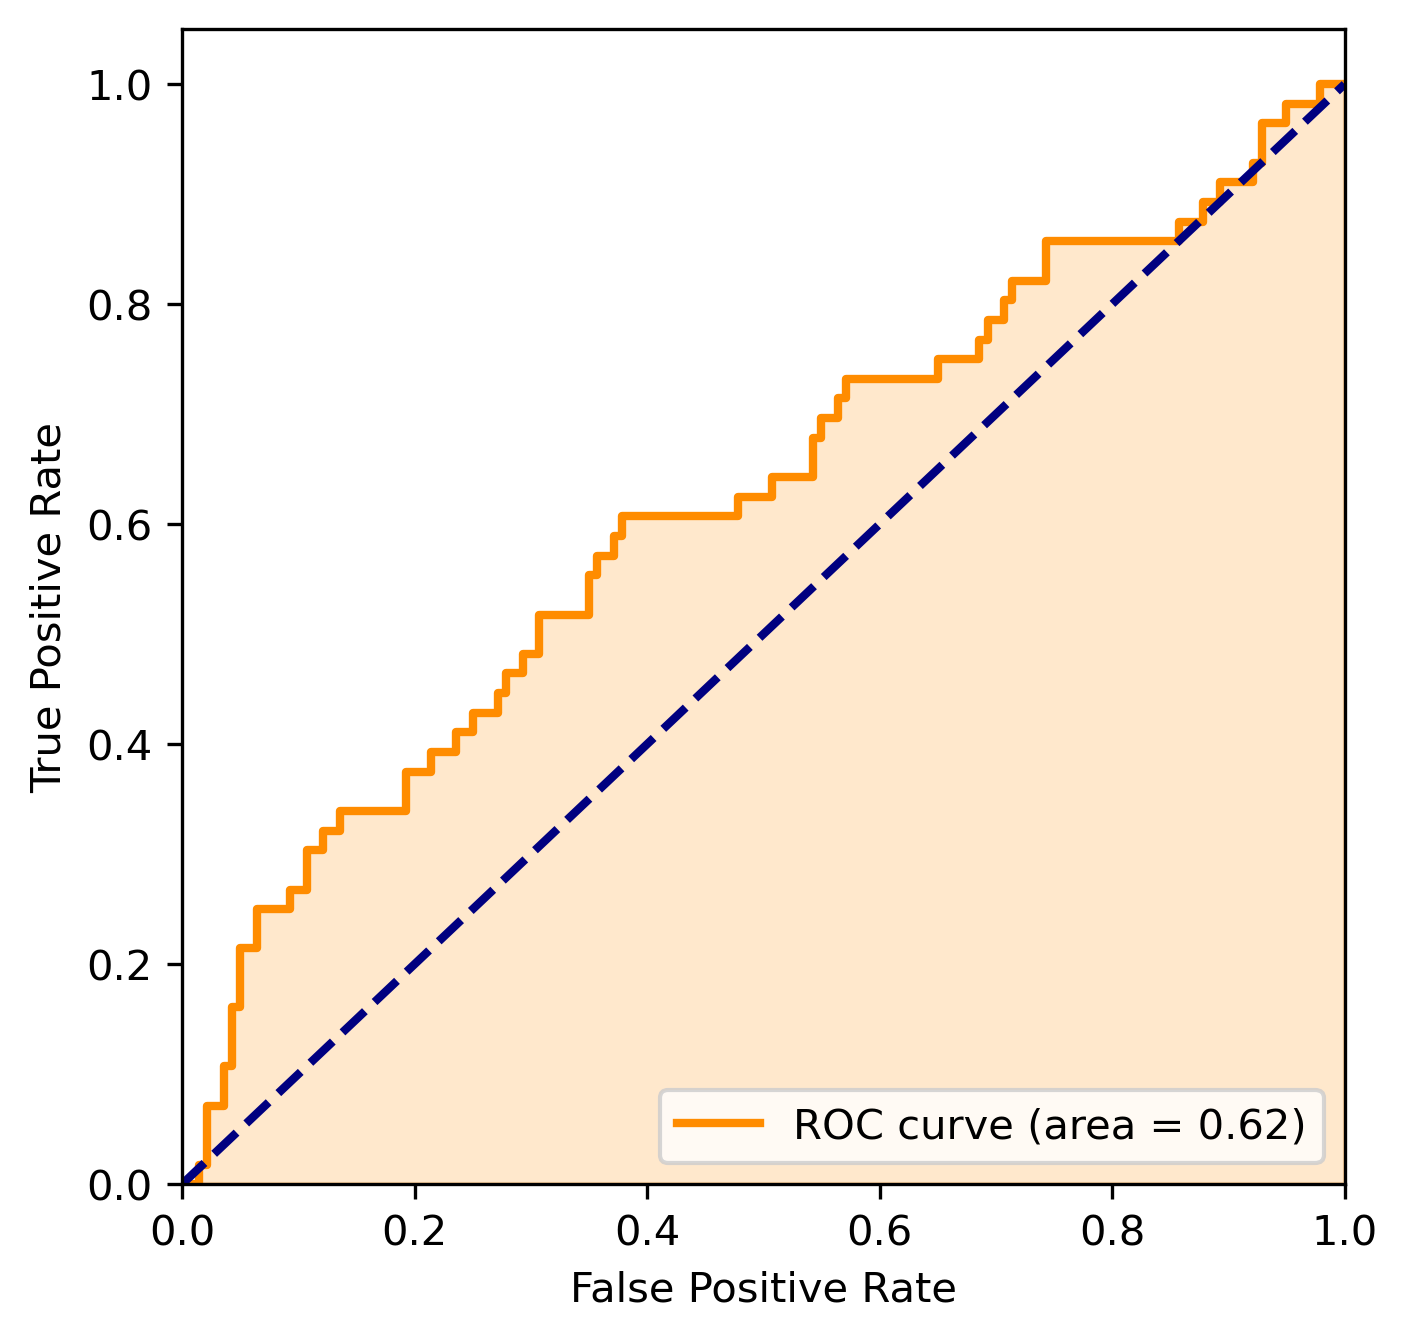

In [22]:
y_scores = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5), dpi=300)

plt.plot(fpr, 
        tpr, 
        color='darkorange', 
        lw=2, 
        label=f'ROC curve (area = {roc_auc:.2f})')

plt.fill_between(fpr, tpr, color='darkorange', alpha=0.2)  # alpha 参数控制填充颜色的透明度


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [23]:
for random_seed in range(0, 1000): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, np.array(y_train).reshape(-1))
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    

    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    
    roc_auc = auc(fpr, tpr)

    print(f"Seed: {random_seed} acc: {accuracy * 100.0} auc: {roc_auc}")

Seed: 0 acc: 78.62595419847328 auc: 0.6531440162271804
Seed: 1 acc: 64.8854961832061 auc: 0.6199059561128527
Seed: 2 acc: 76.33587786259542 auc: 0.6026592455163884
Seed: 3 acc: 75.57251908396947 auc: 0.6883116883116882
Seed: 4 acc: 74.80916030534351 auc: 0.6303571428571428
Seed: 5 acc: 73.2824427480916 auc: 0.5850340136054422
Seed: 6 acc: 73.2824427480916 auc: 0.5411255411255411
Seed: 7 acc: 75.57251908396947 auc: 0.6485380116959064
Seed: 8 acc: 69.46564885496184 auc: 0.5857385398981324
Seed: 9 acc: 80.1526717557252 auc: 0.6148753894080997
Seed: 10 acc: 75.57251908396947 auc: 0.612280701754386
Seed: 11 acc: 72.51908396946564 auc: 0.6525166767738023
Seed: 12 acc: 77.09923664122137 auc: 0.6177358490566037
Seed: 13 acc: 73.2824427480916 auc: 0.5924551638837353
Seed: 14 acc: 74.80916030534351 auc: 0.5720470006184293
Seed: 15 acc: 70.99236641221374 auc: 0.6945054945054945
Seed: 16 acc: 81.67938931297711 auc: 0.7794729542302359
Seed: 17 acc: 75.57251908396947 auc: 0.7028862478777589
Seed: 18